In [1]:
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import cv2
from cv2 import cvtColor
import pickle as pkl
from evaluation import min_match_dist

%load_ext autoreload
%autoreload 2

In [2]:
def to_grayscale(img):
    original_shape = img.shape[:2]
    img = cvtColor(img,cv2.COLOR_BGR2GRAY).astype(float)
    img /= np.max(img)
    return img
def centroid3(img):
    nx, ny, nz = img.shape
    # print(nx,ny,nz)
    imgx = np.sum(np.sum(img, axis=1), axis=1)
    imgy = np.sum(np.sum(img, axis=2), axis=0)
    imgz = np.sum(np.sum(img, axis=0), axis=0)
    denom = np.sum(np.sum(np.sum(img, axis=0), axis=0), axis=0)
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    cz = np.sum(np.linspace(0, nz-1, nz)*imgz)/denom
    
    return cx, cy, cz

def plot_img_at(img, coord, label='Target Location',
    vmin = 0.4,
    vmax = 0.8,ax=None):
    '''
        Plot the 3D slicing view of img at coord.
    '''
    img = np.array(img)
    img += -np.min(img)
    img /= np.max(img)
   
    l,p,s = coord
    
    
    target_marker = 'x'
    target_size = 50
    target_color = 'yellow'

  
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    
    # Only plot the horizontal slice.
    ax.imshow(np.squeeze(img[:,:,s]).T,cmap='gray',vmin=vmin,vmax=vmax)
    ax.scatter(l,p,marker = target_marker,s=target_size,color = target_color,label=label)
    ax.legend()    
    return ax
def visualize_body(img,target_pixel=None,label=None,
                    vmin = 0.4,
                    vmax = 0.8,ax=None):
    img = sitk.GetArrayViewFromImage(img).astype(float)
    img = np.swapaxes(img,0,2)
    if target_pixel is None:
        target_pixel = np.array(centroid3(img))
        label = 'Centroid location'
    plot_img_at(img,np.array(target_pixel,dtype=int),label,vmin,vmax,ax)
    
    
def flip_img(input_img,orders):
    flipped_ct = sitk.Flip(input_img,orders)
    flipped_ct = sitk.GetImageFromArray(sitk.GetArrayFromImage(flipped_ct).astype(np.float64))
    flipped_ct.SetOrigin(input_img.GetOrigin())
    flipped_ct.SetSpacing(input_img.GetSpacing())
    return flipped_ct

In [3]:

body_ct = sitk.ReadImage('./data_Dec23_0/nifty/CT_phantom_regular.nii.gz')
body_ct = flip_img(body_ct,[True,False,False])

In [4]:
import os
obs_path = './data_Dec23_0/observations/'
fs = os.listdir(obs_path)

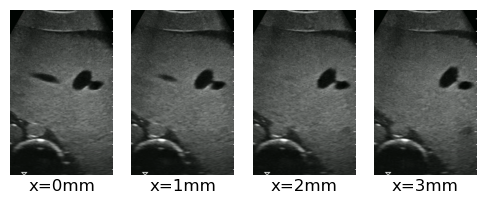

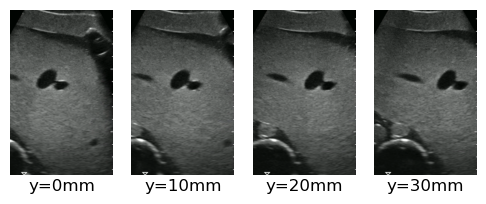

In [5]:
with open('xy_sensitivity.pkl','rb') as fp:
    obs = pkl.load(fp)

x_obs = obs['x_obs']
y_obs = obs['y_obs']

p0 = x_obs[0][0]

i = 0

n_fig = 4
fig,axes = plt.subplots(1,n_fig,figsize=(5,2))

for k in range(4):
    ax = axes[k]
    frame,pose = x_obs[k]
    ax.set_title('x={}mm'.format(k),y=-.15)
    ax.imshow(frame[100:900],cmap='gray')
    ax.axis('off')
fig.tight_layout()
fig.savefig('./figures/x_sensitivity.png')
plt.show()

n_fig = 4

fig,axes = plt.subplots(1,n_fig,figsize=(5,2))
for k in range(4):
    ax = axes[k]
    frame,pose = y_obs[-k-1]
    ax.set_title('y={}mm'.format(10*k),y=-.15)
    ax.imshow(frame[100:900],cmap='gray')
    ax.axis('off')

fig.tight_layout()
fig.savefig('./figures/y_sensitivity.png')
plt.show()


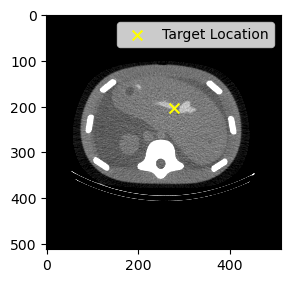

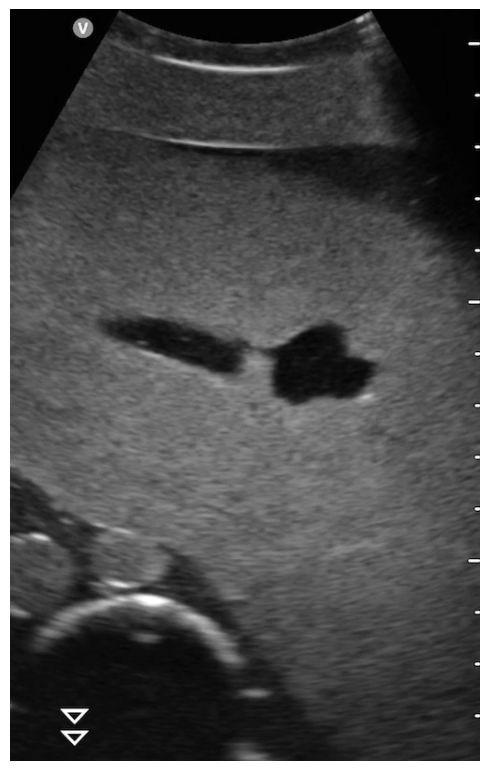

In [5]:
# x_cand = [-80,-40,-20,0,20]
# z_cand = [-10,-5,0,5,10]
from matplotlib import rcParams
for f in fs[3:4]:
    with open(obs_path+f,'rb') as fp:
        obs = pkl.load(fp)
    
    loc = obs['ct_target_loc']
    cframe = obs['with_slice_matching']['center_frame']
    
    pix = body_ct.TransformPhysicalPointToIndex(loc)
    # visualize_vessel(original_vessel_ct,pix,'Target Location')
    # ax = plt.subplot(1,3,1)

    plt.figure(figsize=(3,3))
    ax = plt.gca()
    visualize_body(body_ct,pix,'Target Location',vmin=0.6,vmax=0.8,ax=ax)
    # ax.get_legend().remove()
    ax.axis('on')
    rcParams.update({'font.size': 10})
    plt.tight_layout()
    plt.savefig('./figures/example_target_loc.png')
    plt.show()

    plt.figure(figsize=(5,8))
    ax = plt.gca()
    ax.axis('off')
    ax.imshow(to_grayscale(cframe[100:900]),cmap = 'gray')
    plt.tight_layout()

    plt.savefig('./figures/example_us_scan.png')

    # print('min_match_dist',min_match_dist(obs))

    plt.show()

    

0


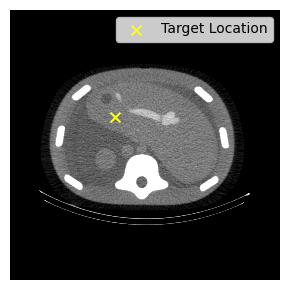

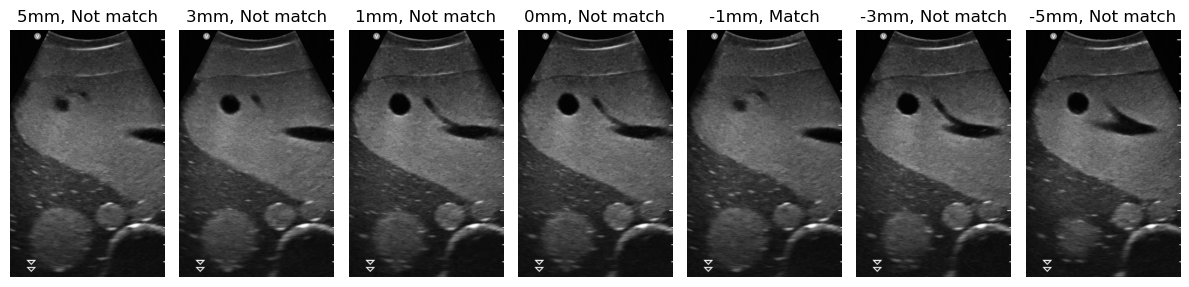

In [49]:
# x_cand = [-80,-40,-20,0,20]
# z_cand = [-10,-5,0,5,10]
from matplotlib import rcParams
for idx, f in enumerate(fs[47:48]):
    print(idx)
    with open(obs_path+f,'rb') as fp:
        obs = pkl.load(fp)
    
    loc = obs['ct_target_loc']
    cframe = obs['with_slice_matching']['center_frame']
    cloc = obs['with_slice_matching']['center_pose']
    frames = obs['with_slice_matching']['all_frames']
    locs = obs['with_slice_matching']['all_poses']
    match = obs['with_slice_matching']['match_status']
    
    pix = body_ct.TransformPhysicalPointToIndex(loc)
    # visualize_vessel(original_vessel_ct,pix,'Target Location')
    # ax = plt.subplot(1,3,1)

    plt.figure(figsize=(3,3))
    ax = plt.gca()
    visualize_body(body_ct,pix,'Target Location',vmin=0.6,vmax=0.8,ax=ax)
    # ax.get_legend().remove()
    ax.axis('off')
    rcParams.update({'font.size': 10})
    plt.tight_layout()
    plt.savefig('./figures/matching_target_loc.png')
    plt.show()

    fig,axes = plt.subplots(1,7,figsize = (12,2.9))
    i = 0
    for frame,l,m in zip(frames,locs,match):
        d = np.array(l)-np.array(cloc)
    
        d = d[0] * 1000
        dist = int(np.floor(np.abs(d)))
        # print(d)
        if dist in [0,1,3,5]:
            ax = axes[i]
            ax.axis('off')
            ax.imshow(to_grayscale(frame[100:900]),cmap = 'gray')
        
            ax.set_title("{:.0f}mm, {}".format(d,'Match' if m else 'Not match'))
          

            # print('min_match_dist',min_match_dist(obs))

            i+=1
    plt.tight_layout()
    plt.savefig('./figures/matching_results.png')
    plt.show()
    

# Plot Success Rate Figures

In [7]:
dists = []
for f in fs:
    with open(obs_path+f,'rb') as fp:
        obs = pkl.load(fp)
    
    dists.append(min_match_dist(obs))

In [8]:
from matplotlib import rc

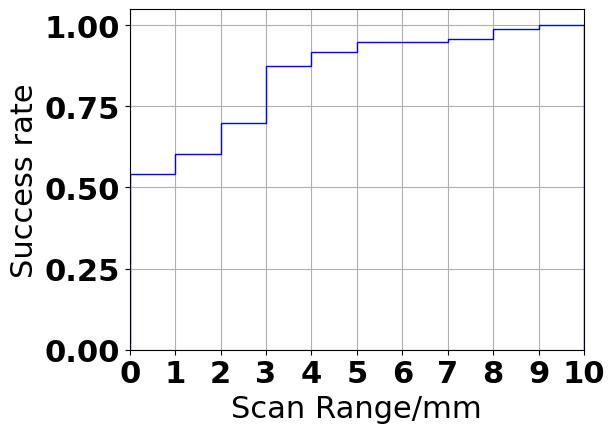

In [9]:
finite_dists = [d*1000 if not np.isinf(d) else 1e6 for d in dists ]

font = { 'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}

rc('font', **font)

f,b,_ = plt.hist(finite_dists,
                 cumulative=True,
                 density=True,histtype='step',
                 bins=np.linspace(0,10,11),
                 color='blue'
                 )

plt.xlim(0,10)
plt.xticks(np.linspace(0,10,11))
plt.xlabel('Scan Range/mm')
plt.ylabel('Success rate')
plt.grid(True)
plt.tight_layout()
plt.savefig('./figures/success_rate.png')
plt.show()


In [10]:
print(f,b)

[0.54166667 0.60416667 0.69791667 0.875      0.91666667 0.94791667
 0.94791667 0.95833333 0.98958333 1.        ] [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
